In [1]:
from SimPEG import dask

In [2]:
import SimPEG.potential_fields as PF
from SimPEG import (
    utils, simulation, maps
)
import matplotlib.pyplot as plt
import numpy as np
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz


# Reproducible Science
np.random.seed(518936)

# data locations

In [3]:
data_grav = utils.io_utils.read_grav3d_ubc('grav_data.obs')


In [4]:
data_mag = utils.io_utils.read_mag3d_ubc('magnetic_data.obs')
rxLoc = data_mag.survey.receiver_locations
rxLoc = PF.magnetics.receivers.Point(rxLoc, components=['tmi'])
inclination = 90.
declination = 0.
strength = 55000.0
inducing_field = (strength, inclination, declination)
srcField = PF.magnetics.sources.SourceField([rxLoc], parameters=inducing_field)
survey_mag = PF.magnetics.survey.Survey(srcField)

In [5]:
mesh = TreeMesh.read_UBC('mesh_CaMP.ubc')

# Define Block Model

In [6]:
mtrue = np.zeros(mesh.nC)
mtrue = utils.model_builder.addBlock(mesh.gridCC, mtrue, np.r_[-3000, -3000, -1500], np.r_[3000, 3000, -500], 2)


In [7]:
geology_model = mesh.read_model_UBC('CaMP_magnetic_synthetic_model.ubc')

In [8]:
def plotting_model(
    ax,
    mesh,
    plot_model,
    clim,
    cmap,
    legend_cb,
    slicex=0.,
    slicey=0.,
    slicez= -550,
    plot_grid=False,
    is_geology=False,
    title='',
    plot_cb=True,
    is_vector=False,
    is_spherical=True,
    quiver_opts = {'scale':0.2, 'scale_units':"inches"},
):
    if is_vector:
        if is_spherical:
            plot_model = utils.mat_utils.spherical2cartesian(
                plot_model.reshape((mesh.nC, 3), order="F")
            )
        plot_model = plot_model.reshape((len(mesh), 3), order='F')
        plotOpts = {'v_type':'CCv', 'view':'vec', 'quiver_opts':quiver_opts}
    else:
        plotOpts = {}
    
    ind_xy = int(np.where(mesh.vectorCCz == mesh.vectorCCz[np.abs(mesh.vectorCCz-slicez).argmin()])[0][0])
    ind_xz = int(np.where(mesh.vectorCCy == mesh.vectorCCy[np.abs(mesh.vectorCCy-slicey).argmin()])[0][0])
    ind_yz = int(np.where(mesh.vectorCCx == mesh.vectorCCx[np.abs(mesh.vectorCCx-slicex).argmin()])[0][0])

    indslicezplot = mesh.gridCC[:,2] == mesh.vectorCCz[ind_xy]
    indsliceyplot = mesh.gridCC[:,1] == mesh.vectorCCy[ind_xz]
    indslicexplot = mesh.gridCC[:,0] == mesh.vectorCCx[ind_yz]
    
    #plot true model
    for j, (plane, indd) in enumerate(zip([[0,1],[0,2],], [indslicezplot, indsliceyplot,])):
        _, _, CS = utils.plot2Ddata(
            mesh.gridCC[indd][:,plane],geology_model[indd],nx=200,ny=200,
            clim=[0,2],
             contourOpts={'alpha':0},
             ax=ax[j],
             level=True,
             ncontour=2,
             levelOpts={
                 'colors':'k','linewidths':5,#'linestyles':, 
                 #'label':'True geology contour'
             },
            method='nearest'
        )   
        CS.collections[0].set_label('True geology model (contours)')
    #PLAN MAP
    mm = mesh.plotSlice(
        plot_model,normal='Z', ind=ind_xy, clim=clim,
        grid=plot_grid,pcolorOpts={'cmap':cmap,},
        ax=ax[0],
        **plotOpts,
    )
    ax[0].set_xlabel('')#'X (m)', fontsize=18)
    ax[0].set_ylabel('Y (m)', fontsize=labelsize)
    
    ax[0].plot(
        [-16000,16000],np.ones(2)*mesh.vectorCCy[ind_xz],
        linestyle='dashed',linewidth=3,c='xkcd:dark gray', 
        label='cross-section location'
    )
    ax[0].legend(fontsize=labelsize)
    ax[0].set_yticks(np.linspace(-15000,15000,7))
    ax[0].set_yticklabels(
        ['${}$'.format(lbl) for lbl in np.linspace(-15000,15000,7,dtype='int')], 
        va='center', ha='center'
    )
    ax[0].set_xticklabels('');
    ax[0].set_xlabel('');
    
    #EW SECTION
    #fix the colorbar for vector plot
    if is_vector:
        mm = mesh.plotSlice(
            np.linalg.norm(plot_model, axis=1),normal='Y',ind=ind_xz, clim = clim,
            grid=plot_grid,pcolorOpts={'cmap':cmap,'alpha':1},
            ax=ax[1],
        )
    mesh.plotSlice(
        plot_model,normal='Y',ind=ind_xz, clim = clim,
        grid=plot_grid,pcolorOpts={'cmap':cmap,},
        ax=ax[1],
        **plotOpts,
    )
    ax[1].set_xlabel('X (m)', fontsize=labelsize)
    ax[1].set_ylabel('Z (m)', fontsize=labelsize)
    ax[1].plot(
        [-16000,16000],np.ones(2)*mesh.vectorCCz[ind_xy],
        linestyle='dashed',linewidth=3,c='xkcd:dark gray'
    )
    ax[1].set_yticks([-6000,-3000,0])
    ax[1].set_yticklabels(
        ['$-6000$','$-3000$','$0$'], 
        va='center', ha='center'
    )
    
    #General formatting
    for axx in ax:
        axx.set_aspect('equal')
        axx.tick_params(labelsize=ticksize)
        axx.set_title('')#ax[0].get_title(),fontsize=20)
        axx.tick_params(axis='y',rotation=90)
    ax[0].set_title(title,fontsize=titlesize)
    #ADJUST SPACE IN FIGURE
    #fig.subplots_adjust(hspace=-0.45)

    #colorbar
    #cbaxes = fig.add_axes([0.95, 0.5, 0.025, 0.25])
    #fix the colorbar for vector plot
    if plot_cb:
        cb = plt.colorbar(mm[0],cax=ax[2])
        cb.ax.set_aspect(20)
        if is_geology:
            cb.set_ticks([0.33,1,1.67])
            cb.ax.set_yticklabels(
                ['Background','Carbonated', 'Serpentinized'],
                va='center',ha='center'
            )
        cb.set_label(legend_cb, fontsize=labelsize)
        cb.outline.set_edgecolor('k')
        cb.ax.tick_params(labelsize=ticksize,rotation=90,pad=15)
    else:
        ax[2].axis('off')
        cb = None

    return ax, cb

# Simulation Mag

In [9]:
mmag = mtrue.copy()
mmag[mtrue==1] = 0.05
mmag[mtrue==2] = 0.15

In [10]:
np.unique(mmag)

array([0.  , 0.15])

In [11]:
simulation_mag = PF.magnetics.simulation.Simulation3DIntegral(
    survey=survey_mag,
    mesh=mesh,
    chiMap=maps.IdentityMap(nP=mesh.nC),
    actInd=np.ones_like(mtrue,dtype='bool'),
    #store_sensitivities="forward_only",
)

# Compute predicted data for some model


In [12]:
noise_floor = 1.
relative_error = 0.
dpred_mag = simulation_mag.make_synthetic_data(mmag,relative_error=relative_error,noise_floor=noise_floor, f=None, add_noise=True)

((3010, 3010), (5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5219))
Computing sensitivities to local ram
[########################################] | 100% Completed |  6min 15.0s


Text(0.5, 1.0, 'MAGNETIC RESPONSE')

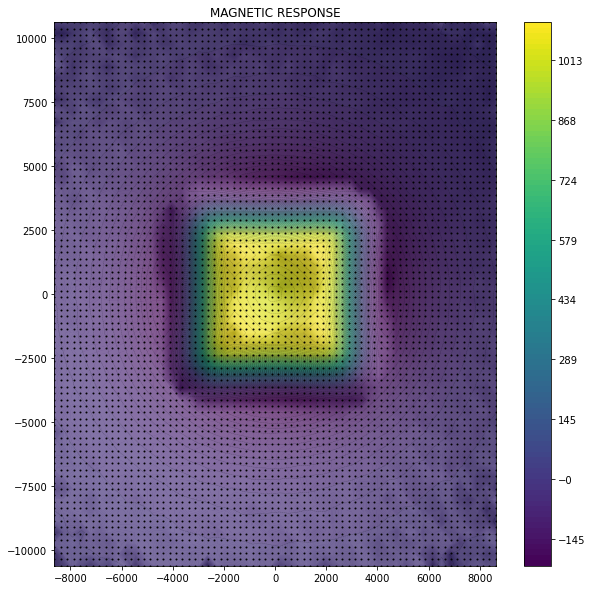

In [13]:
fig = plt.figure(figsize=(10,10))

#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=-1, grid=True,pcolorOpts={'cmap':'Greys'},ax=plt.gca())
plt.gca().set_aspect('equal')
#plt.gca().scatter(X,Y,s=1)
#rxLoc = np.c_[utils.mkvc(X.T), utils.mkvc(Y.T), utils.mkvc(Z.T)]
mm = utils.plot2Ddata(dpred_mag.survey.receiver_locations,dpred_mag.dobs,
                      ax=plt.gca(),level=True, 
                     nx=50,ny=50, dataloc=True,ncontour=100, shade=True,
                      contourOpts={'cmap':'viridis'},
                      levelOpts={'colors':'k','linestyles':'dotted','linewidths':0.25,}
                      )
plt.colorbar(mm[0])
plt.gca().set_title('MAGNETIC RESPONSE')

In [14]:
dpred_mag_3block = simulation_mag.make_synthetic_data(geology_model,relative_error=relative_error,noise_floor=noise_floor, f=None, add_noise=True)

Text(0.5, 1.0, 'MAGNETIC RESPONSE')

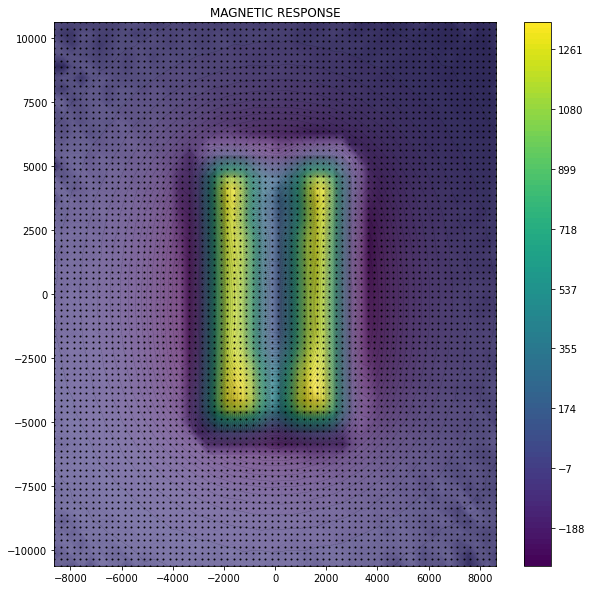

In [15]:
fig = plt.figure(figsize=(10,10))

#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=-1, grid=True,pcolorOpts={'cmap':'Greys'},ax=plt.gca())
plt.gca().set_aspect('equal')
#plt.gca().scatter(X,Y,s=1)
#rxLoc = np.c_[utils.mkvc(X.T), utils.mkvc(Y.T), utils.mkvc(Z.T)]
mm = utils.plot2Ddata(dpred_mag_3block.survey.receiver_locations,dpred_mag_3block.dobs,
                      ax=plt.gca(),level=True, 
                     nx=50,ny=50, dataloc=True,ncontour=100, shade=True,
                      contourOpts={'cmap':'viridis'},
                      levelOpts={'colors':'k','linestyles':'dotted','linewidths':0.25,}
                      )
plt.colorbar(mm[0])
plt.gca().set_title('MAGNETIC RESPONSE')

# Simulation Grav

In [82]:
# Background of 2.9 g/cc
mden = mtrue.copy()
mden[mtrue==1] = 0.3
mden[mtrue==2] = -0.2

In [83]:
np.unique(mden)

array([-0.2,  0. ])

In [40]:
simulation_grav = PF.gravity.simulation.Simulation3DIntegral(
    survey=data_grav.survey,
    mesh=mesh,
    rhoMap=maps.IdentityMap(nP=mesh.nC),
    actInd=np.ones_like(mtrue,dtype='bool'),
)



((3010, 3010), (5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5219))
Computing sensitivities to local ram
[########################################] | 100% Completed |  3min 56.3s


In [84]:
noise_floor = 0.05
relative_error = 0.
# Compute predicted data for some model
dpred_grav = simulation_grav.make_synthetic_data(mden,relative_error=relative_error,noise_floor=noise_floor, f=None, add_noise=True)

Text(0.5, 1.0, 'GRAVITY RESPONSE')

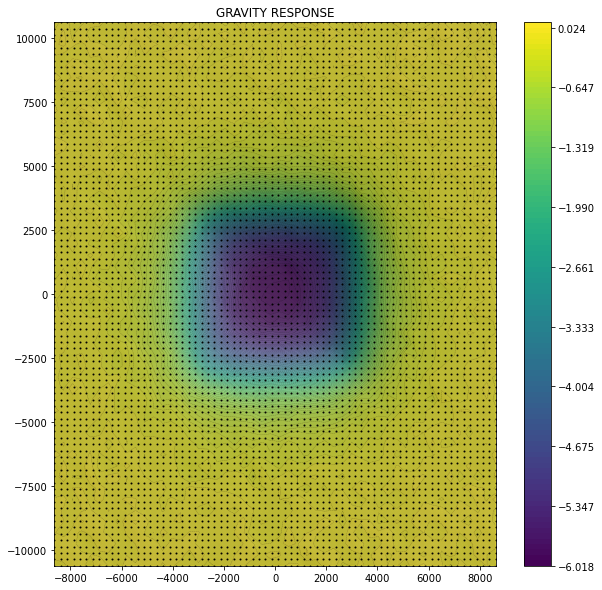

In [85]:
fig = plt.figure(figsize=(10,10))

#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=-1, grid=True,pcolorOpts={'cmap':'Greys'},ax=plt.gca())
plt.gca().set_aspect('equal')
#plt.gca().scatter(X,Y,s=1)
#rxLoc = np.c_[utils.mkvc(X.T), utils.mkvc(Y.T), utils.mkvc(Z.T)]
mm = utils.plot2Ddata(data_grav.survey.receiver_locations[:,:2],-dpred_grav.dobs,
                      ax=plt.gca(),level=True, 
                     nx=50,ny=50, dataloc=True,ncontour=100, shade=True,
                      contourOpts={'cmap':'viridis'},
                      levelOpts={'colors':'k','linestyles':'dotted','linewidths':0.25}
                      )
plt.colorbar(mm[0])
plt.gca().set_title('GRAVITY RESPONSE')

# save files

In [86]:
#mesh.writeUBC('mesh_CaMP.ubc')
mesh.write_model_UBC("1block_synthetic_model.ubc", mden)
mesh.write_model_UBC("1block_synthetic_model.ubc", mmag)

In [87]:
utils.io_utils.write_grav3d_ubc('1block_gravity_data.obs', dpred_grav)


Observation file saved to: 1block_gravity_data.obs
Observation file saved to: 1block_magnetic_data.obs


In [17]:
utils.io_utils.write_mag3d_ubc('1block_magnetic_data.obs', dpred_mag)

Observation file saved to: 1block_magnetic_data.obs


In [16]:
utils.io_utils.write_mag3d_ubc('3blocks_magnetic_data.obs', dpred_mag_3block)

Observation file saved to: 3blocks_magnetic_data.obs


In [88]:
import seaborn
import matplotlib.colors as cm

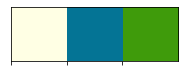

In [89]:
# create geology colorcode
colors = ["xkcd:off white", 'xkcd:sea blue', "#3f9b0b",] #,'#7CFC79', '#080A7F'
seaborn.palplot(colors)
geocmap = cm.ListedColormap(colors, name='from_list', N=None)

/Users/thibautastic/GITHUB/simpeg/SimPEG/utils/plot_utils.py:134: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(X, Y, DATA, **levelOpts)
/Users/thibautastic/GITHUB/simpeg/SimPEG/utils/plot_utils.py:134: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(X, Y, DATA, **levelOpts)


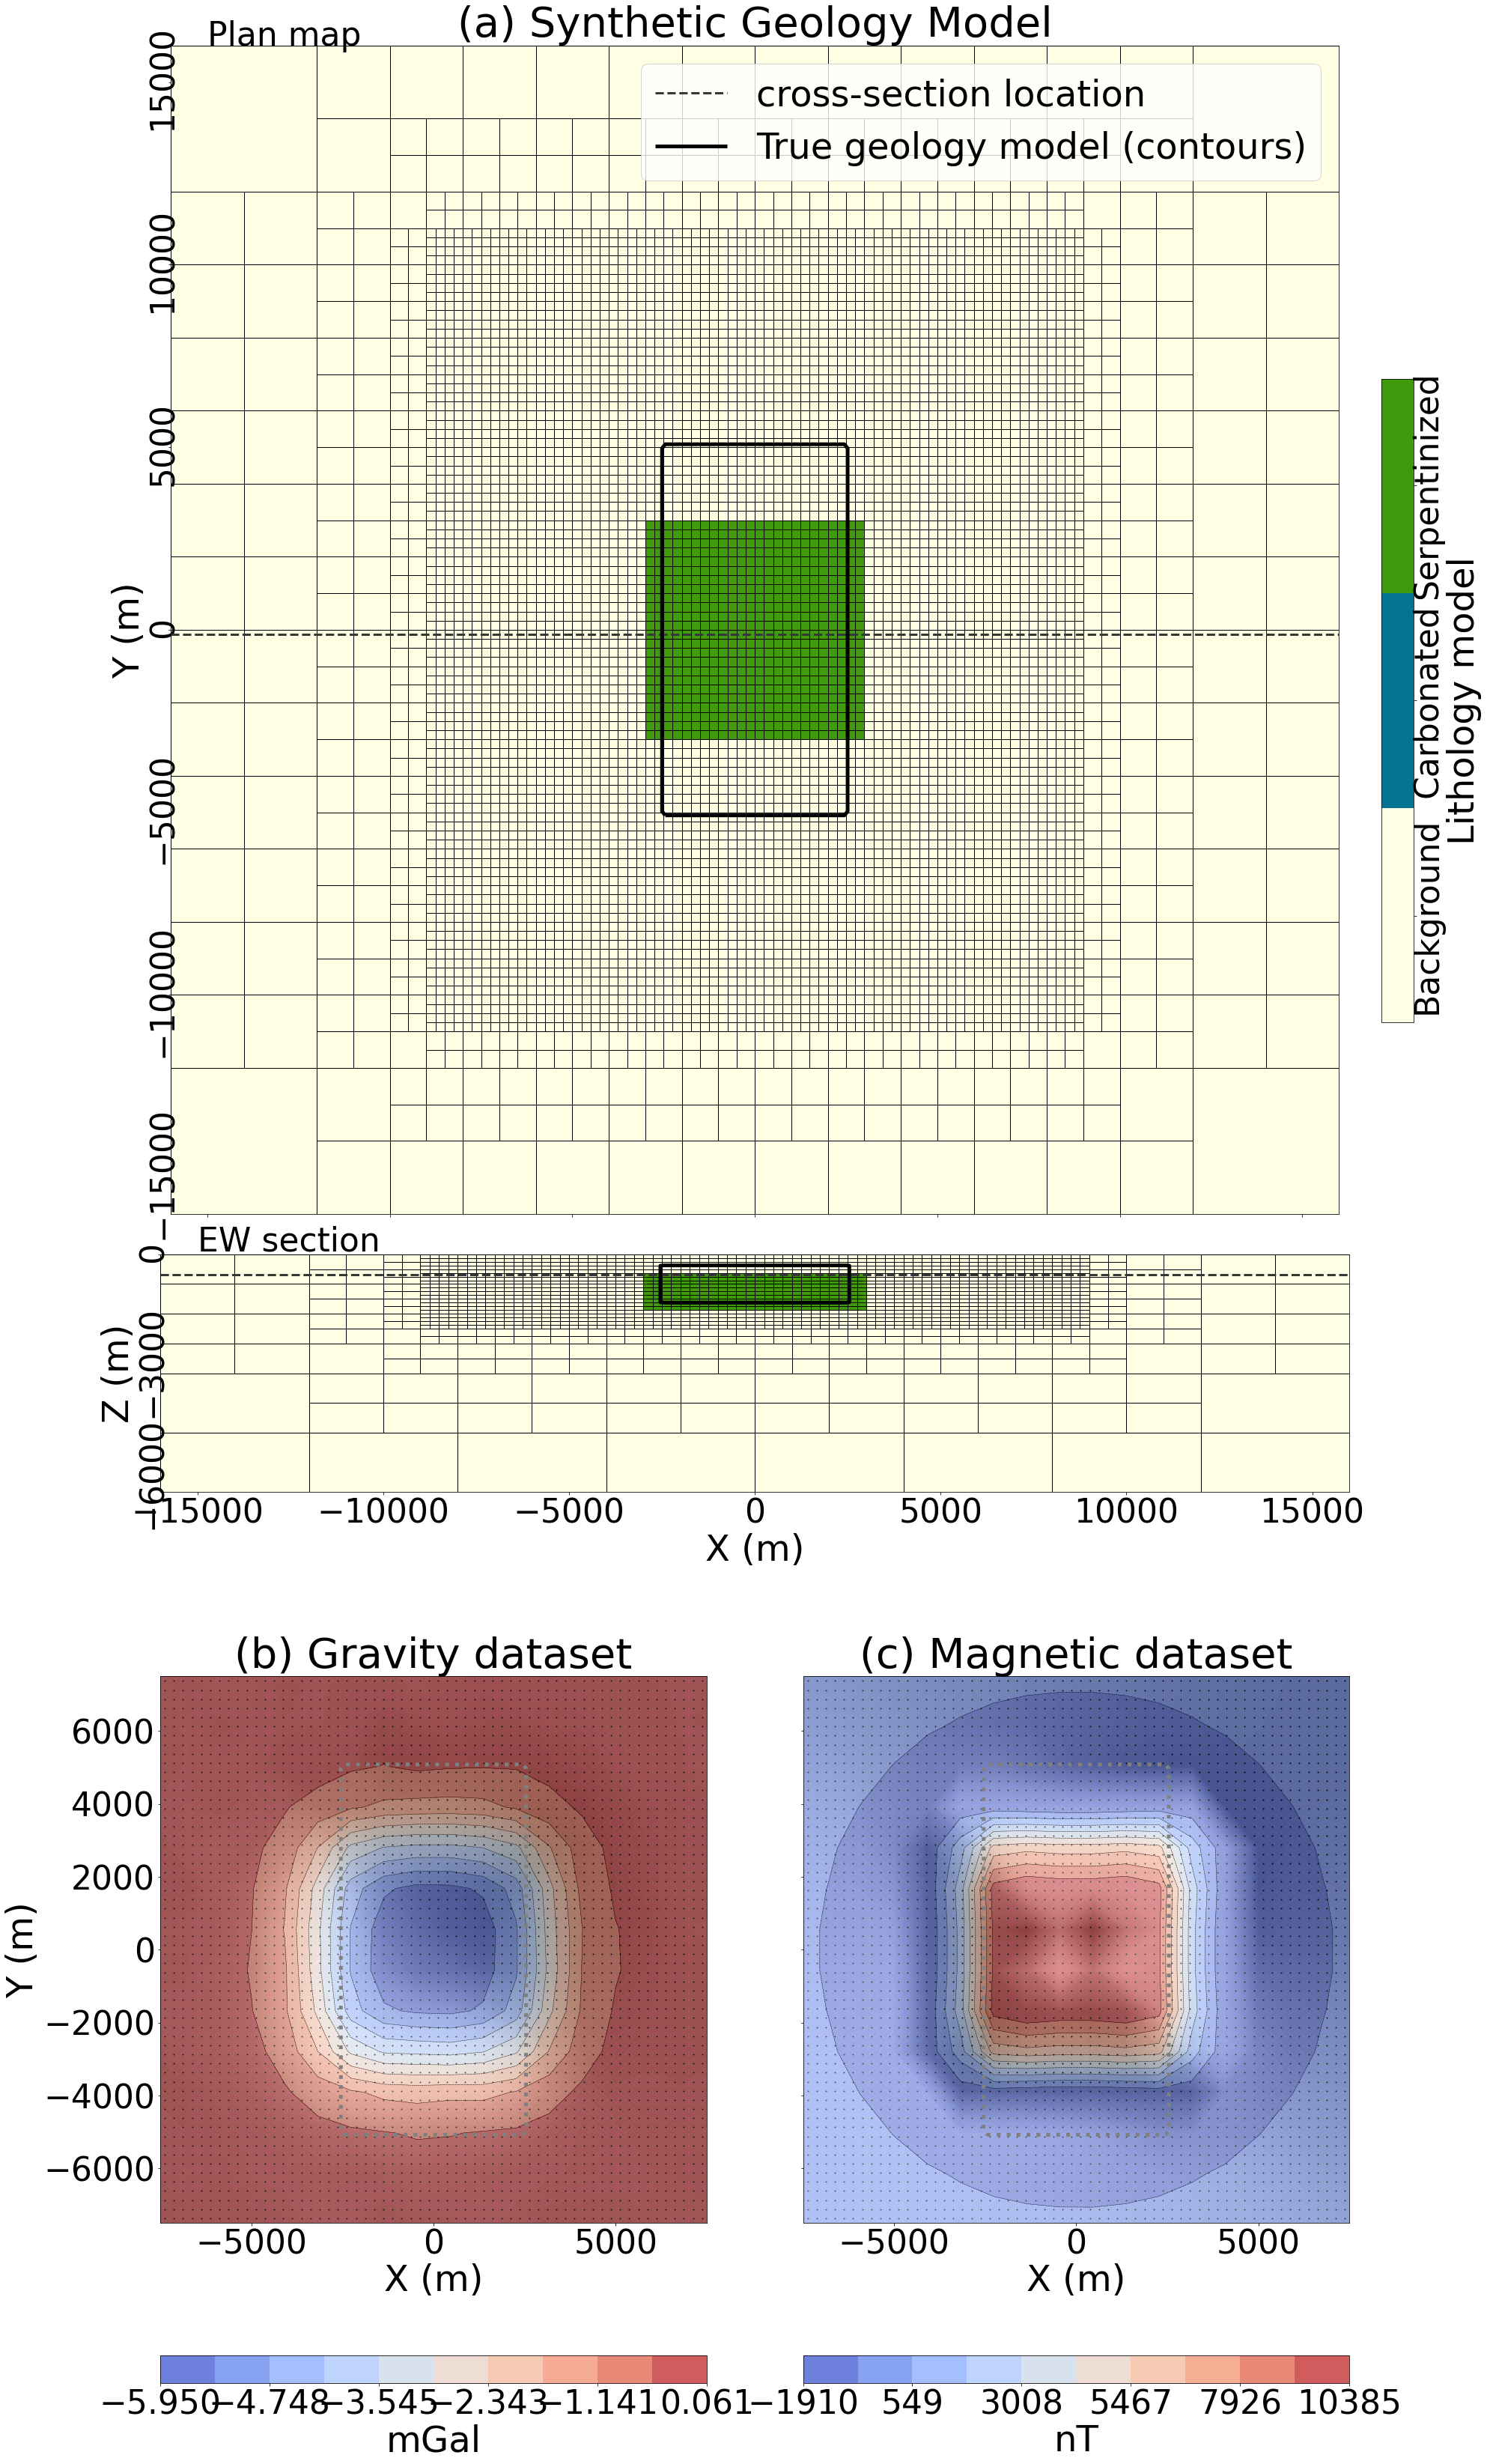

In [90]:
titlesize = 28 * 2
labelsize = 24 * 2
ticksize = 22 * 2

fig = plt.figure(figsize=(3*10,3*20))
ax0 = plt.subplot2grid((35,20,),(0, 0),colspan=19,rowspan=17)
ax1 = plt.subplot2grid((35,20,),(17, 0),colspan=19,rowspan=4)
ax2 = plt.subplot2grid((35,20,),(0, 19),colspan=1,rowspan=19)
ax3 = plt.subplot2grid((35,20,),(22, 0),colspan=9,rowspan=15)
ax4 = plt.subplot2grid((35,20,),(22, 10),colspan=9,rowspan=15)
fig.subplots_adjust(hspace=1,wspace=1)
ax = [ax0,ax1,ax2]
ax, cb = plotting_model(
    ax=ax,
    mesh=mesh,
    plot_model=mtrue,
    clim=[0,2],
    cmap=geocmap,
    legend_cb='Lithology model',
    slicex=0.,
    slicey=0.,
    slicez= -550,
    plot_grid=True,
    is_geology=True
)
#ax[0].scatter(
#    data_grav.survey.receiver_locations[:,0],
#    data_grav.survey.receiver_locations[:,1],
#    label='Data locations',c='xkcd:dark blue',s=2)
ax[0].legend(fontsize=labelsize)
ax[0].set_title('(a) Synthetic Geology Model', fontsize=titlesize)
ax[0].text(-15000,16000,'Plan map',fontdict={'fontsize':ticksize})
ax[1].text(-15000,100,'EW section',fontdict={'fontsize':ticksize})

##################################
ax = [ax3,ax4]
ax[0].set_xlim([-7500,7500])
ax[1].set_xlim([-7500,7500])
ax[0].set_ylim([-7500,7500])
ax[1].set_ylim([-7500,7500])
ax[0].set_xlabel('X (m)', fontsize=labelsize)
ax[1].set_xlabel('X (m)', fontsize=labelsize)
ax[0].set_ylabel('Y (m)', fontsize=labelsize)

for axx in ax:
    axx.tick_params(labelsize=ticksize)
#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=int(-10), grid=True,pcolorOpts={'cmap':'Greys'},ax=ax[0])
mm = utils.plot2Ddata(dpred_grav.survey.receiver_locations, -dpred_grav.dobs,
                      ax=ax[0],level=True, 
                     nx=20,ny=20, dataloc=False,ncontour=10, shade=True,
                      contourOpts={'cmap':'coolwarm', 'alpha':0.8,}, 
                      levelOpts={'colors':'k','linewidths':0.5, 'linestyles':'dashed'}
                      )
ax[0].scatter(dpred_grav.survey.receiver_locations[:,0],dpred_grav.survey.receiver_locations[:,1],label='Data locations',c='k',s=1)
#ax[0].legend(fontsize=16,loc=4)
ax[0].set_aspect(1)
ax[0].set_title('(b) Gravity dataset', fontsize=titlesize)
cb = plt.colorbar(mm[0],ax=ax[0], orientation='horizontal')
cb.set_label('mGal', fontsize=labelsize)
cb.ax.tick_params(labelsize=ticksize)

#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=int(-10), grid=True,pcolorOpts={'cmap':'Greys'},ax=ax[1])
mm = utils.plot2Ddata(dpred_mag.survey.receiver_locations,dpred_mag.dobs,
                      ax=ax[1],level=True, 
                     nx=20,ny=20, dataloc=False,ncontour=10, shade=True,
                      contourOpts={'cmap':'coolwarm', 'alpha':0.8,},
                     levelOpts={'colors':'k','linewidths':0.5, 'linestyles':'dashed'}
)
ax[1].scatter(dpred_mag.survey.receiver_locations[:,0],dpred_mag.survey.receiver_locations[:,1],label='Data locations',c='k',s=1)

ax[1].set_title('(c) Magnetic dataset', fontsize=titlesize)
cb = plt.colorbar(mm[0],ax=ax[1], orientation='horizontal')
cb.set_label('nT', fontsize=labelsize)
ax[1].set_yticklabels([])
cb.ax.tick_params(labelsize=ticksize)

#overlay true geology model for comparison
indz = -9
indslicezplot = mesh.gridCC[:,2] == mesh.vectorCCz[indz]
for i in range(2):
    _, _, CS = utils.plot2Ddata(
            mesh.gridCC[indslicezplot][:,[0,1]],geology_model[indslicezplot],
            nx=200,ny=200,
             contourOpts={'alpha':0},
             clim=[0,2],
             ax=ax[i],
             level=True,
             ncontour=2,
             levelOpts={'colors':'grey','linewidths':5,'linestyles':'dotted',},
            method='nearest'
    )
    CS.collections[0].set_label('True geology outline')
    #ax[i].legend(fontsize=16,loc=4)
    ax[i].set_aspect(1)
plt.show()

